# __Temperature Forecasting__

## __1. Preparando o Ambiente__

In [183]:

# Bibliotecas para manipulção de dados
import numpy as np
import pandas as pd

# Bibliotecas para visualização
import matplotlib as m
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose 

from pmdarima.arima.utils import ndiffs

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error




# Filtrando warings
import warnings
warnings.filterwarnings("ignore")

m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 12,7
m.style.use('ggplot')
%matplotlib inline

## __2. Análise de Dados__

### Carregando Dados

In [2]:
df = pd.read_csv("data.csv")
df.head()

,datetime,Miami
0,2012-10-01 12:00:00,NaN
1,2012-10-01 13:00:00,299.720000
2,2012-10-01 14:00:00,299.732518
3,2012-10-01 15:00:00,299.766579
4,2012-10-01 16:00:00,299.800641


### Definindo datetime como index

In [3]:
df["datetime"] = pd.to_datetime(df["datetime"])
df.set_index("datetime", inplace=True)
df.head()

,Miami
datetime,
2012-10-01 12:00:00,NaN
2012-10-01 13:00:00,299.720000
2012-10-01 14:00:00,299.732518
2012-10-01 15:00:00,299.766579
2012-10-01 16:00:00,299.800641


In [4]:
df.rename(columns={"Miami": "temperatura"}, inplace=True)

In [5]:
df.describe()

,temperatura
count,44448.000000
mean,34712.492683
std,95224.021759
min,275.233333
25%,296.440000
50%,299.389667
75%,302.069625
max,307002.000000


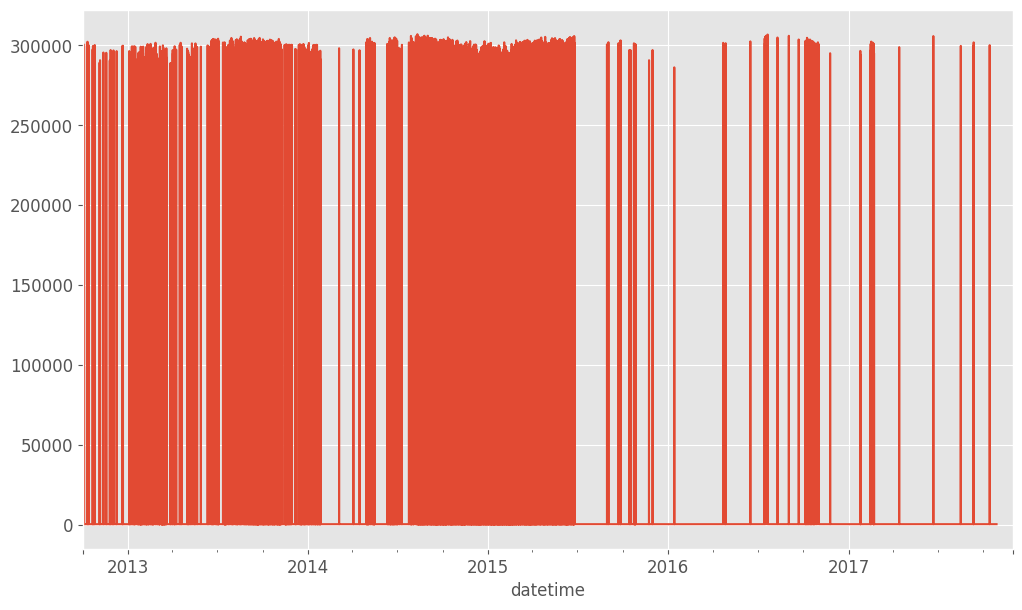

In [6]:
df.temperatura.plot();

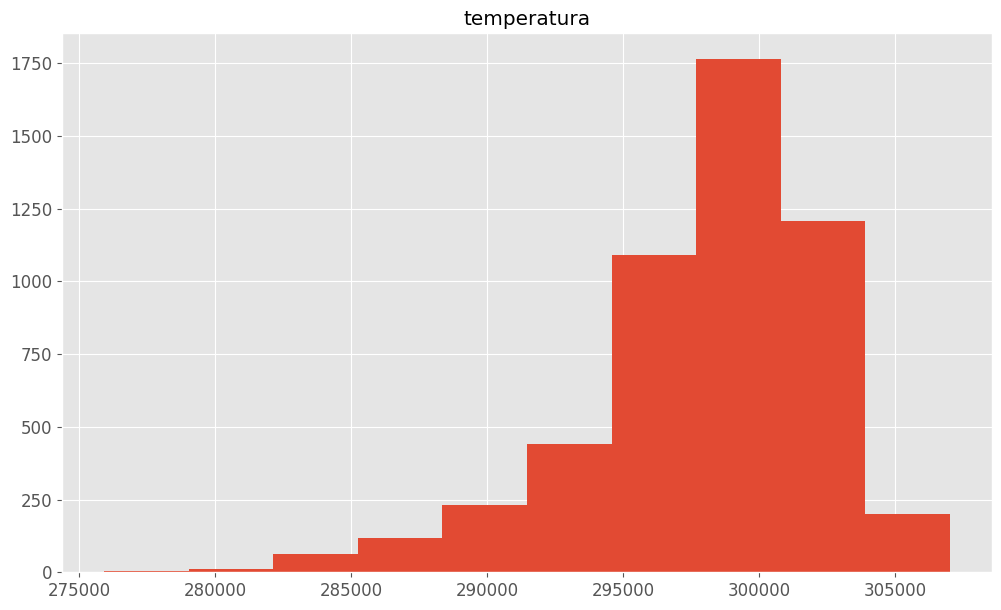

In [7]:
valores_mal_formatados = df[df.temperatura > 350]
valores_mal_formatados.hist();

In [8]:
valores_mal_formatados[valores_mal_formatados.temperatura < 272000]

,temperatura
datetime,


In [9]:
def corrige_temperatura(temp):
    if temp > 350:
        if temp > 250000:
            return temp / 1000
        return np.NaN
    return temp

In [10]:
df["temperatura"] = df.temperatura.apply(corrige_temperatura)

In [11]:
df.describe()

,temperatura
count,44448.000000
mean,298.181274
std,4.190185
min,275.233333
25%,296.030000
50%,298.880000
75%,300.992375
max,308.680000


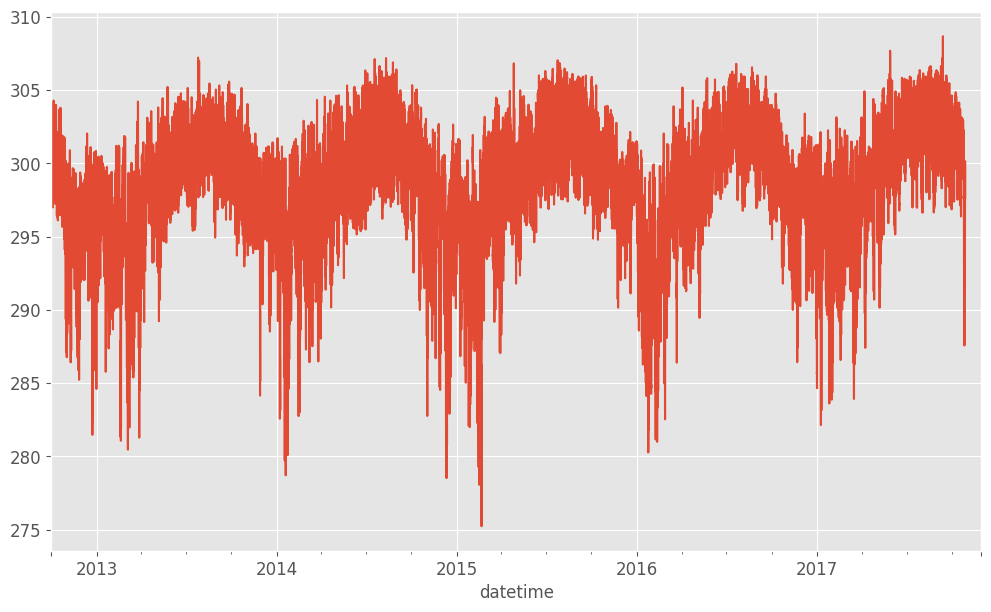

In [12]:
df.temperatura.plot();

In [13]:
df_interpolated = df.interpolate(method="time")

In [14]:
df.tail()

,temperatura
datetime,
2017-11-29 20:00:00,NaN
2017-11-29 21:00:00,NaN
2017-11-29 22:00:00,NaN
2017-11-29 23:00:00,NaN
2017-11-30 00:00:00,NaN


<AxesSubplot: xlabel='datetime'>

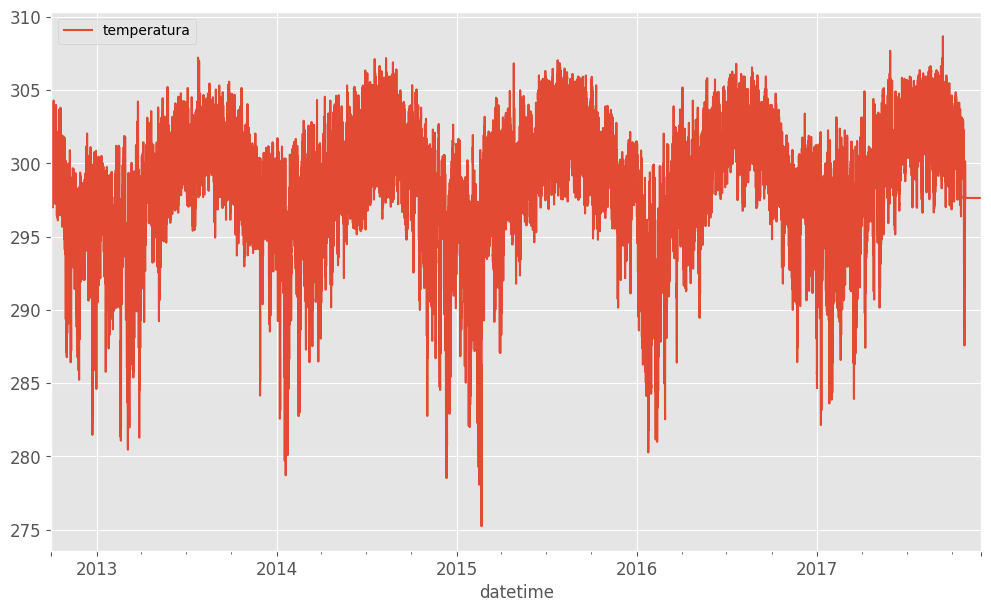

In [15]:
df_interpolated.plot()

In [16]:
ultimo_valor_valido = df[~df.temperatura.isna()].index[-1]
ultimo_valor_valido

Timestamp('2017-10-28 00:00:00')

In [17]:
df_clean = df.loc[:ultimo_valor_valido]

In [18]:
df_clean.tail()

,temperatura
datetime,
2017-10-27 20:00:00,299.92
2017-10-27 21:00:00,299.81
2017-10-27 22:00:00,299.15
2017-10-27 23:00:00,298.90
2017-10-28 00:00:00,297.64


In [19]:
df_clean.isna().sum()

temperatura    13
dtype: int64

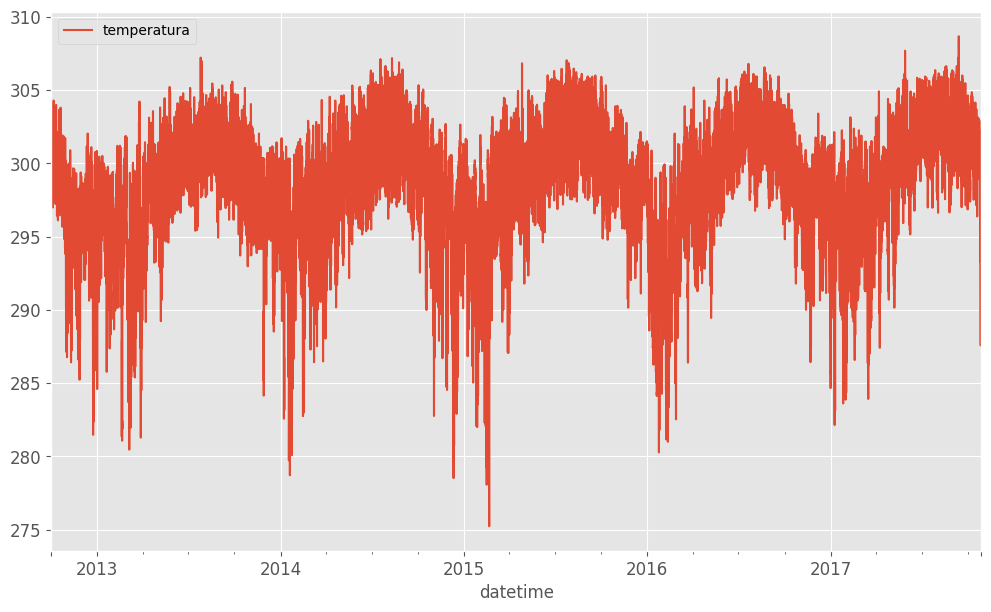

In [20]:
df_clean = df_clean.interpolate(method="time")
df_clean.plot();

In [21]:
df_clean.isna().sum()

temperatura    1
dtype: int64

In [22]:
df_clean.head()

,temperatura
datetime,
2012-10-01 12:00:00,NaN
2012-10-01 13:00:00,299.720000
2012-10-01 14:00:00,299.732518
2012-10-01 15:00:00,299.766579
2012-10-01 16:00:00,299.800641


In [23]:
df_clean.dropna(inplace=True)

In [24]:
df_clean["celsius"] = df_clean.temperatura - 273.15

In [25]:
df_clean.groupby(df_clean.index.year).mean()["celsius"]

datetime
2012    22.832328
2013    24.822875
2014    24.553171
2015    25.463788
2016    25.059253
2017    25.977980
Name: celsius, dtype: float64

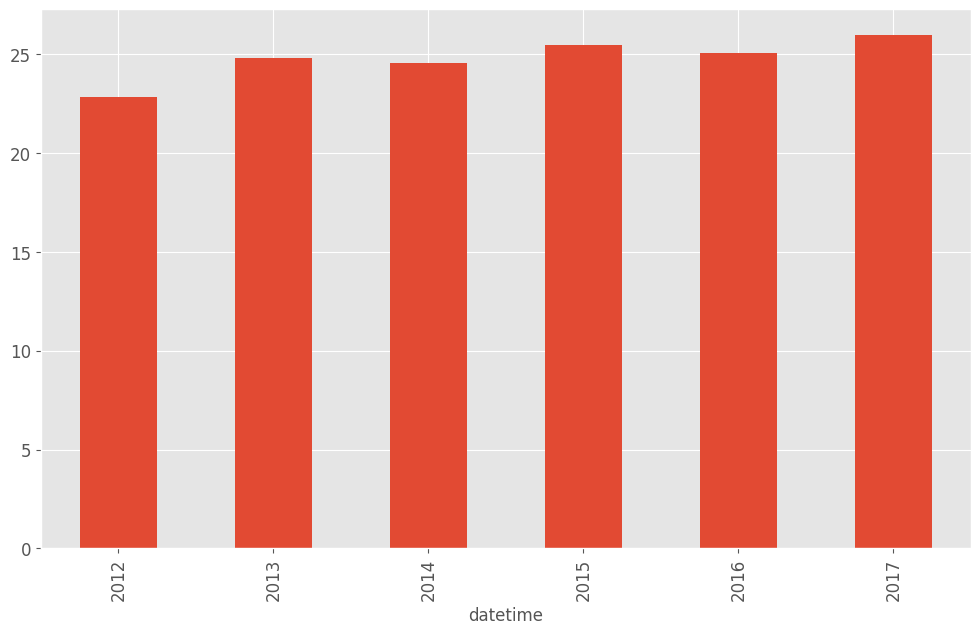

In [26]:
df_clean.groupby(df_clean.index.year).mean()["celsius"].plot.bar();

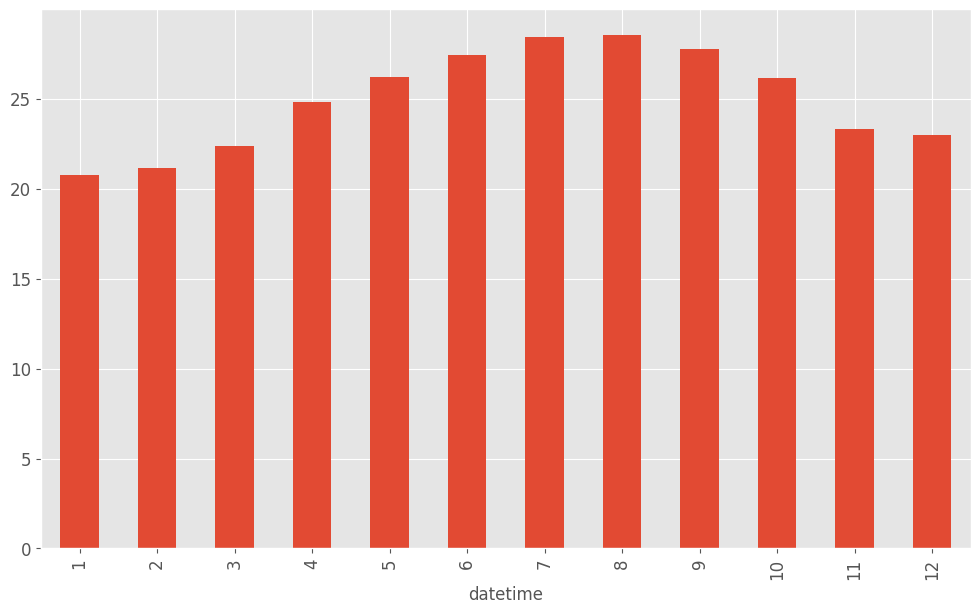

In [27]:
df_clean.groupby(df_clean.index.month).mean()["celsius"].plot.bar();

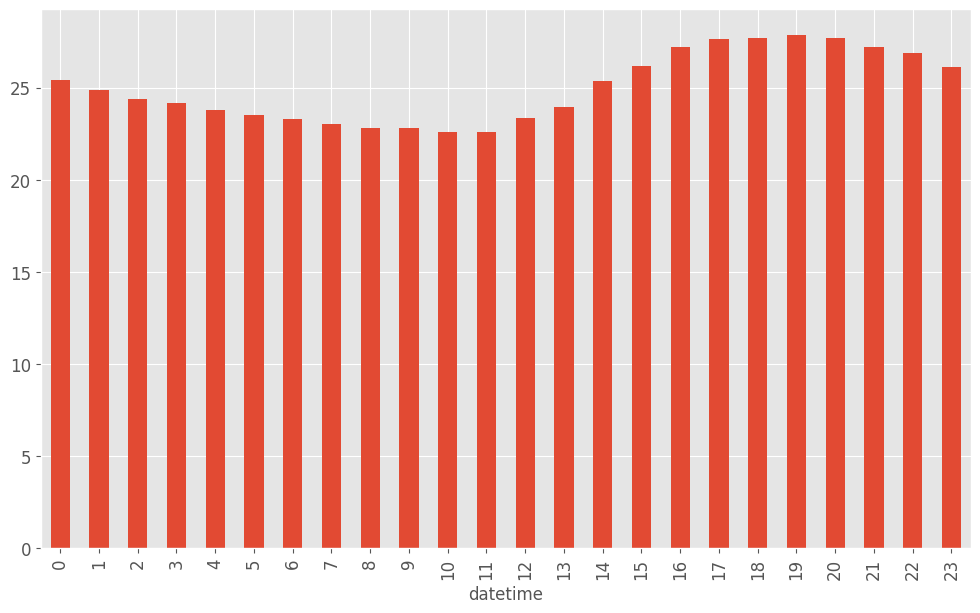

In [28]:
df_clean.groupby(df_clean.index.hour).mean()["celsius"].plot.bar();

<AxesSubplot: xlabel='datetime'>

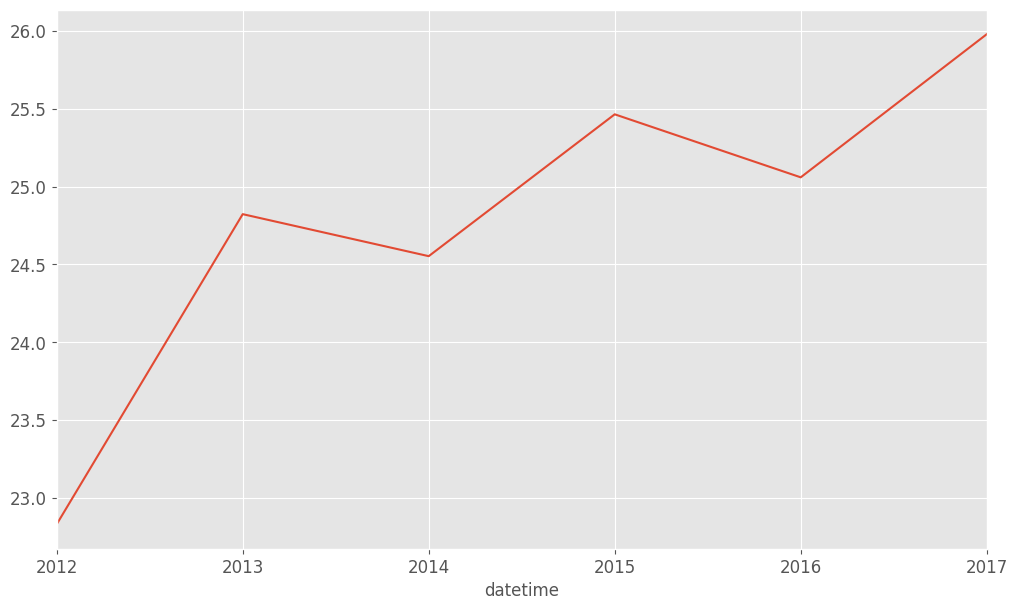

In [29]:
df_clean["celsius"].resample("Y").mean().plot()

<AxesSubplot: xlabel='datetime'>

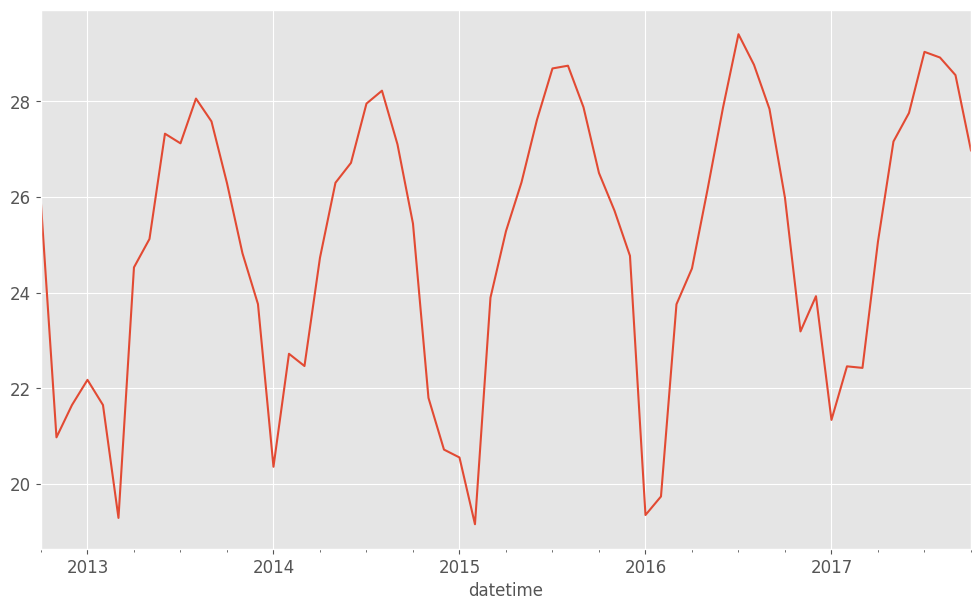

In [30]:
df_clean["celsius"].resample("M").mean().plot()

<AxesSubplot: xlabel='datetime'>

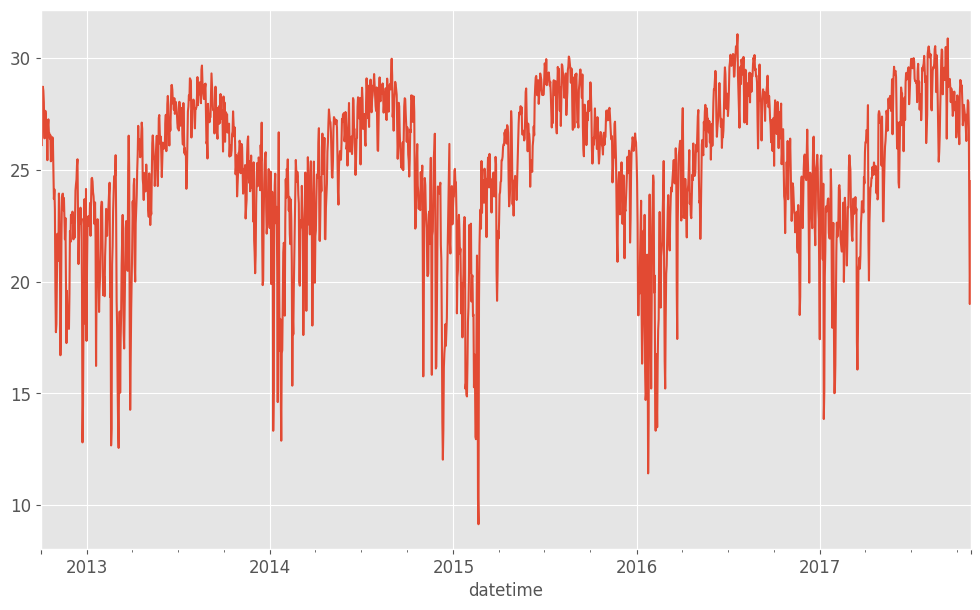

In [31]:
df_clean["celsius"].resample("D").mean().plot()

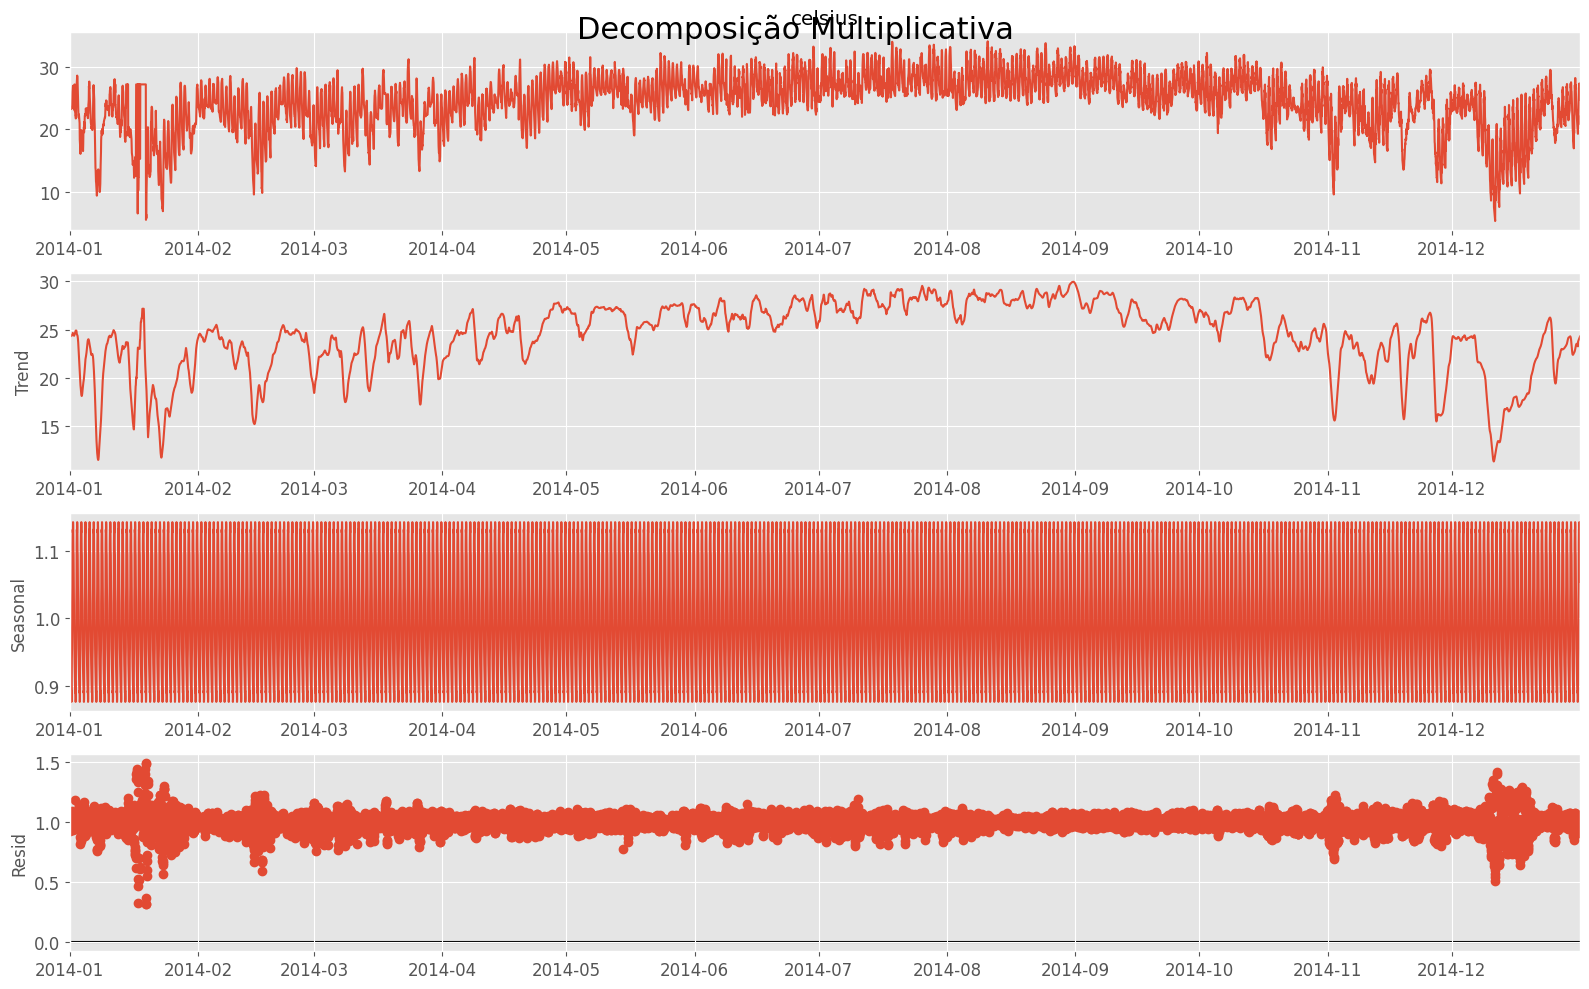

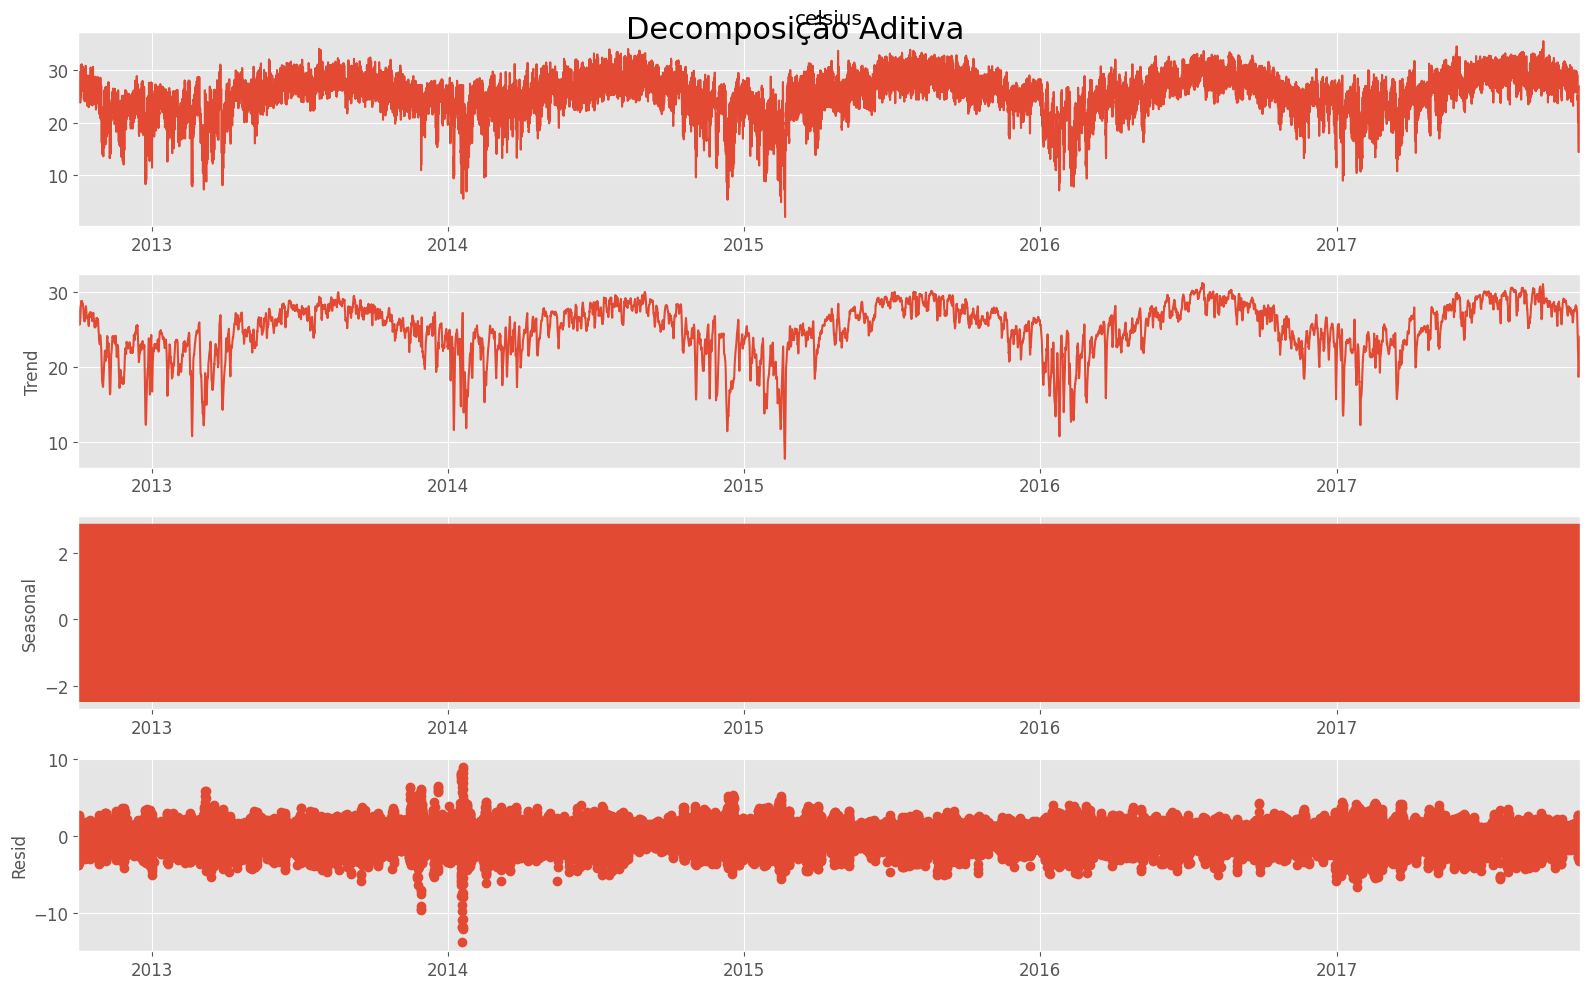

In [61]:
# Multiplicative Decomposition 
decomposicao_multiplicativa = seasonal_decompose(df_clean.celsius["2014"], model = 'multiplicative', 
                                                        extrapolate_trend = 'freq')

# Additive Decomposition
decomposicao_aditiva = seasonal_decompose(df_clean.celsius, model = 'aditive', 
                                                 extrapolate_trend = 'freq')

# Plot
plt.rcParams.update({'figure.figsize': (16,10)})
decomposicao_multiplicativa.plot().suptitle('Decomposição Multiplicativa', fontsize = 22)
decomposicao_aditiva.plot().suptitle('Decomposição Aditiva', fontsize = 22)
plt.show()

## Separando dados de Treino e Teste

In [37]:
df_clean.index.max()

Timestamp('2017-10-28 00:00:00')

In [38]:
df_train = df_clean[:'2017-09']
df_train.index.max()

Timestamp('2017-09-30 23:00:00')

In [39]:
df_test = df_clean['2017-10':]

In [40]:
df_test.index.min()

Timestamp('2017-10-01 00:00:00')

<AxesSubplot: xlabel='datetime'>

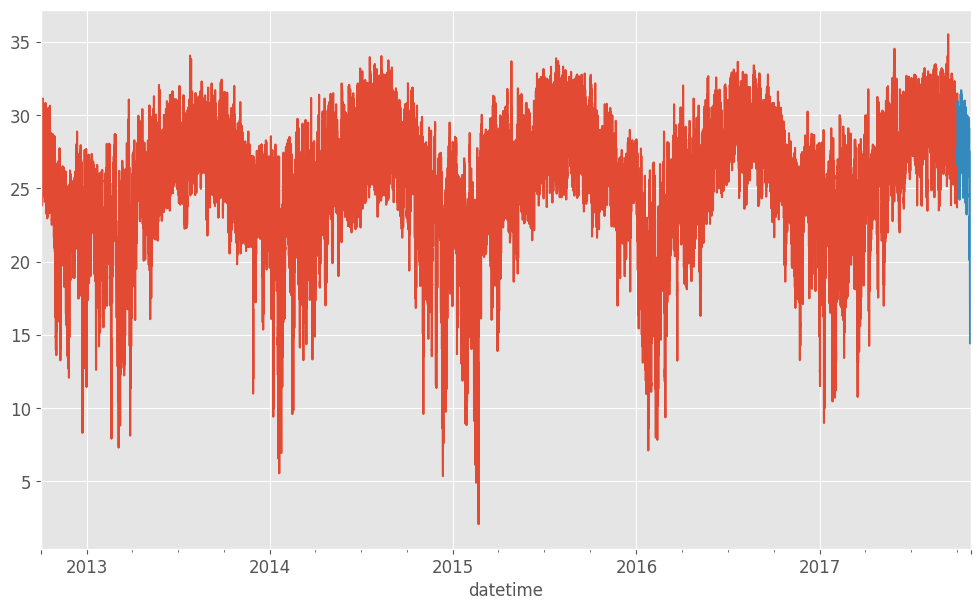

In [41]:
df_train["celsius"].plot()
df_test["celsius"].plot()


### Baseline

In [42]:
df_pred = df_test.copy()
df_pred.drop(columns=["temperatura", "celsius"], inplace=True)
df_pred["baseline"] = df_train["celsius"].mean()

In [43]:
df_pred.head()

,baseline
datetime,
2017-10-01 00:00:00,25.002769
2017-10-01 01:00:00,25.002769
2017-10-01 02:00:00,25.002769
2017-10-01 03:00:00,25.002769
2017-10-01 04:00:00,25.002769


<AxesSubplot: xlabel='datetime'>

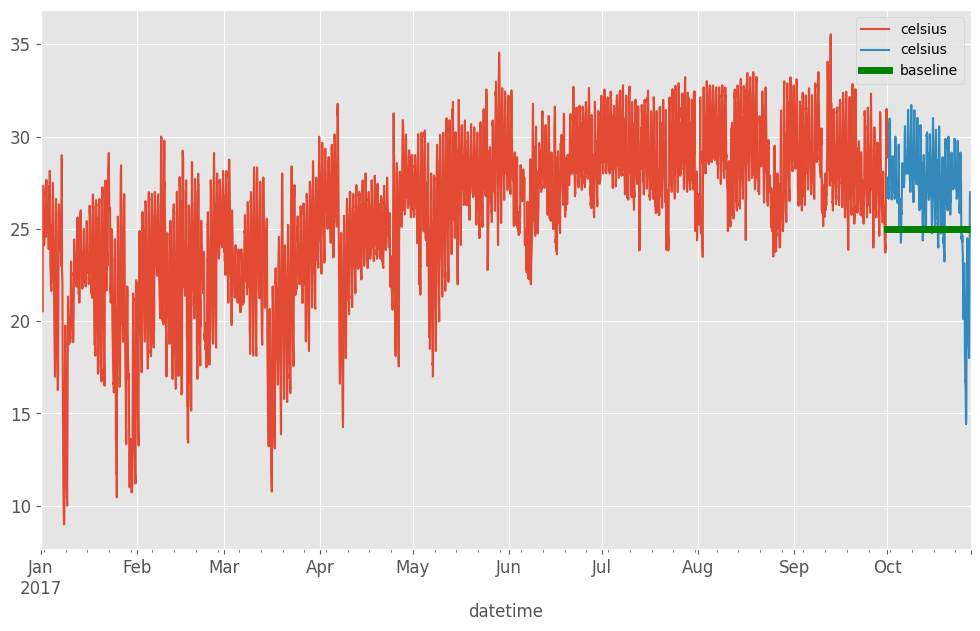

In [44]:
df_train["celsius"]["2017":].plot(legend="treino")
df_test["celsius"].plot(legend="teste")
df_pred["baseline"].plot(legend="previsão", color="green", linewidth=5)

In [45]:
df_train["celsius"]["2017":]

datetime
2017-01-01 00:00:00    22.62
2017-01-01 01:00:00    22.11
2017-01-01 02:00:00    22.50
2017-01-01 03:00:00    22.62
2017-01-01 04:00:00    22.63
                       ...  
2017-09-30 19:00:00    31.49
2017-09-30 20:00:00    31.22
2017-09-30 21:00:00    31.11
2017-09-30 22:00:00    30.50
2017-09-30 23:00:00    28.87
Name: celsius, Length: 6552, dtype: float64

In [46]:
df_pred["baseline_year"] = df_train["celsius"]["2016-10":"2017-09"].mean()

<AxesSubplot: xlabel='datetime'>

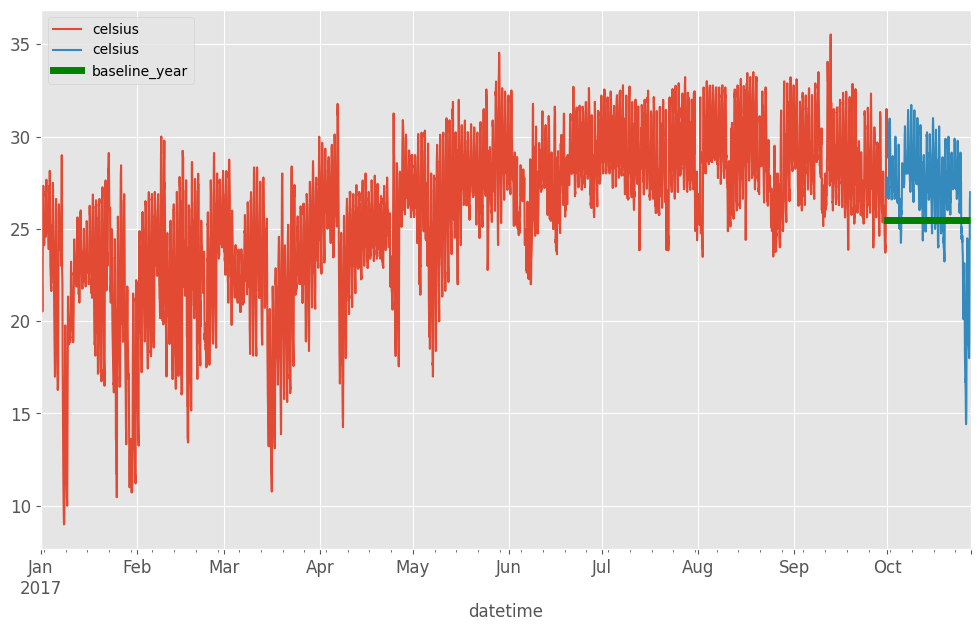

In [47]:
df_train["celsius"]["2017":].plot(legend="treino")
df_test["celsius"].plot(legend="teste")
df_pred["baseline_year"].plot(legend="previsão", color="green", linewidth=5)

In [48]:
rmse_baseline = mean_squared_error(df_test["celsius"].values, df_pred["baseline"].values, squared=False)
mape_baseline = mean_absolute_percentage_error(df_test["celsius"].values, df_pred["baseline"].values)

In [49]:
df_metrics = pd.DataFrame({"RMSE": [rmse_baseline], "MAE":[mape_baseline]}, index=["baseline"])

In [50]:
df_metrics

,RMSE,MAE
baseline,3.375403,0.109517


In [62]:
# Função para testar a estacionaridade
def testa_estacionaridade(serie):
    
    # Calcula estatísticas móveis
    rolmean = serie.rolling(window = 24).mean()
    rolstd = serie.rolling(window = 24).std()

    # Plot das estatísticas móveis
    orig = plt.plot(serie, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Média Móvel')
    std = plt.plot(rolstd, color = 'black', label = 'Desvio Padrão')
    plt.legend(loc = 'best')
    plt.title('Estatísticas Móveis - Média e Desvio Padrão')
    plt.show()
    
    # Teste Dickey-Fuller:
    # Print
    print('\nResultado do Teste Dickey-Fuller:\n')

    # Teste
    dfteste = adfuller(serie, autolag = 'AIC')

    # Formatando a saída
    dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste',
                                               'Valor-p',
                                               'Número de Lags Consideradas',
                                               'Número de Observações Usadas'])

    # Loop por cada item da saída do teste
    for key, value in dfteste[4].items():
        dfsaida['Valor Crítico (%s)'%key] = value

    # Print
    print (dfsaida)
    
    # Testa o valor-p
    if dfsaida[1] > 0.05:
        print('Essa série provavelmente não é estacionária.')
    else:
        print('Essa série provavelmente é estacionária.')

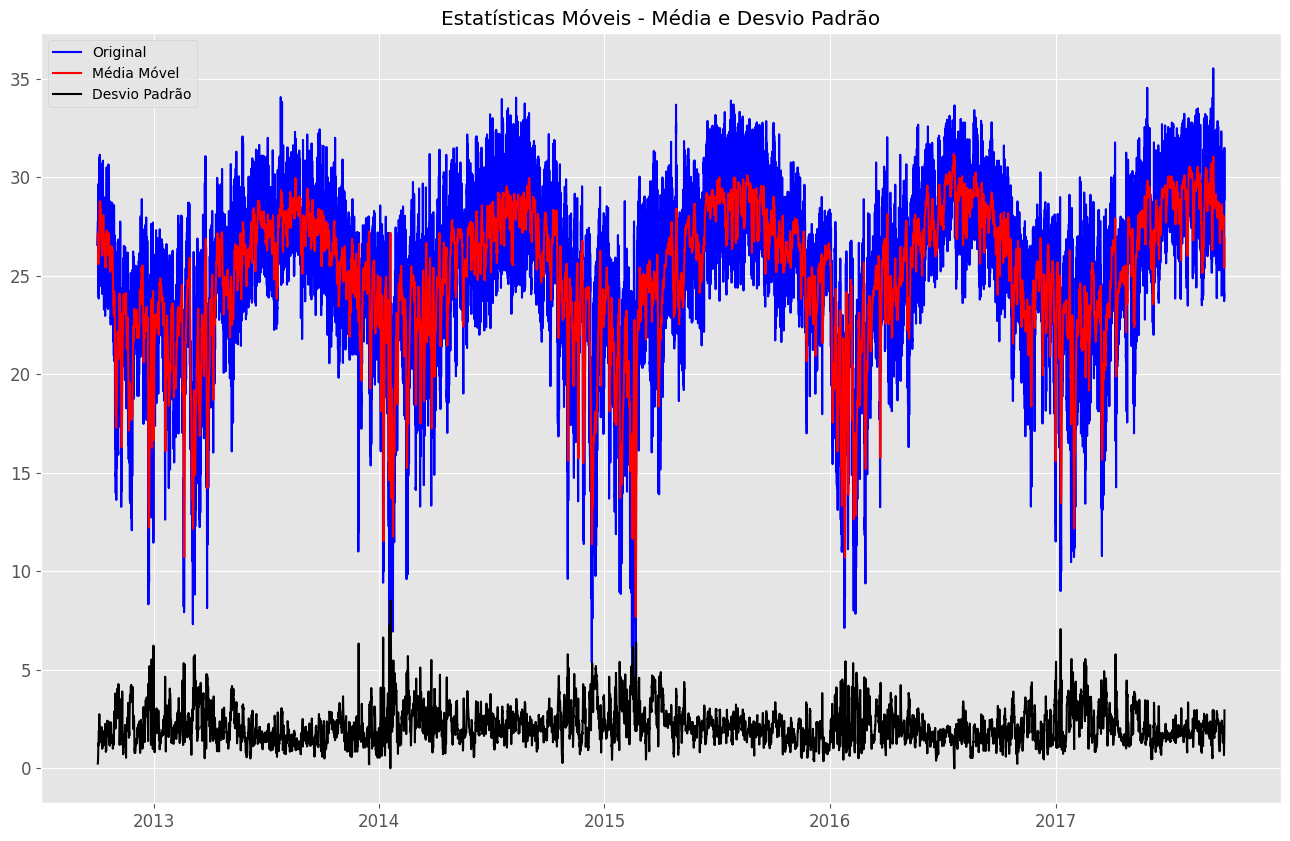


Resultado do Teste Dickey-Fuller:

Estatística do Teste           -1.044455e+01
Valor-p                         1.491842e-18
Número de Lags Consideradas     5.300000e+01
Número de Observações Usadas    4.375700e+04
Valor Crítico (1%)             -3.430499e+00
Valor Crítico (5%)             -2.861606e+00
Valor Crítico (10%)            -2.566805e+00
dtype: float64
Essa série provavelmente é estacionária.


In [63]:
testa_estacionaridade(df_train.celsius)

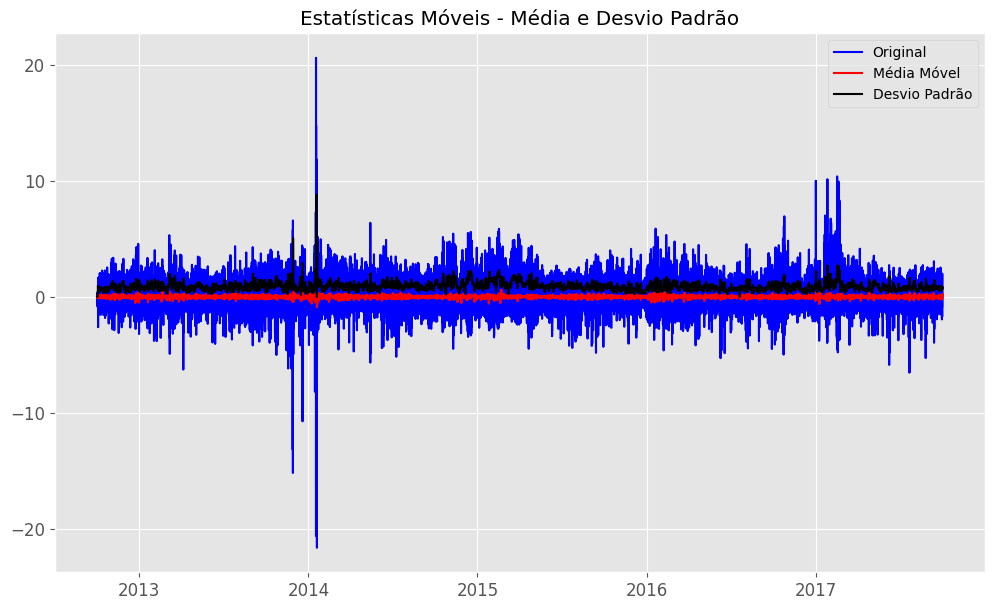


Resultado do Teste Dickey-Fuller:

Estatística do Teste              -33.611537
Valor-p                             0.000000
Número de Lags Consideradas        55.000000
Número de Observações Usadas    43754.000000
Valor Crítico (1%)                 -3.430499
Valor Crítico (5%)                 -2.861606
Valor Crítico (10%)                -2.566805
dtype: float64
Essa série provavelmente é estacionária.


In [68]:
testa_estacionaridade(df_train.celsius.diff().dropna())

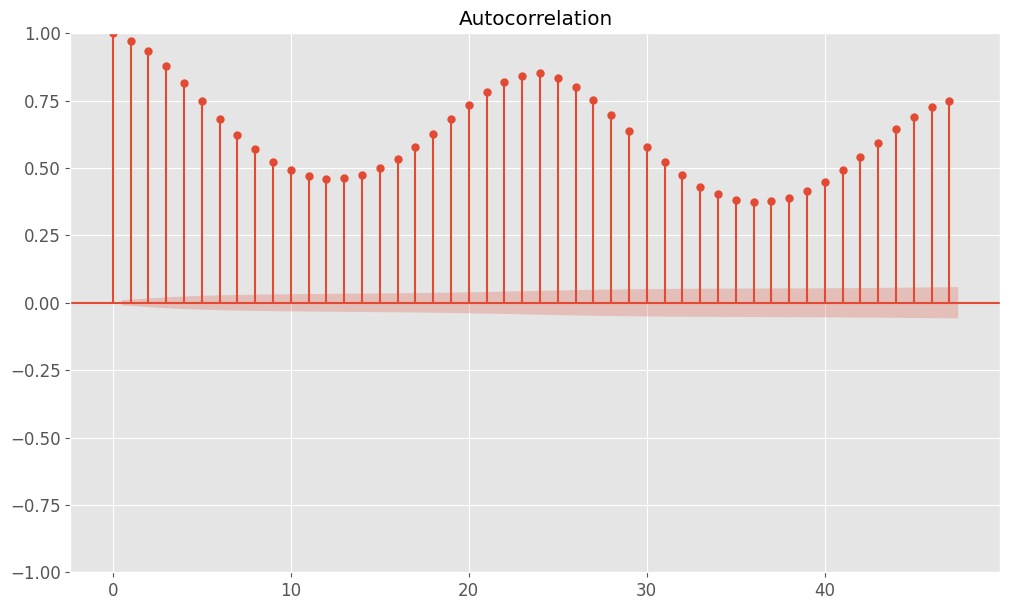

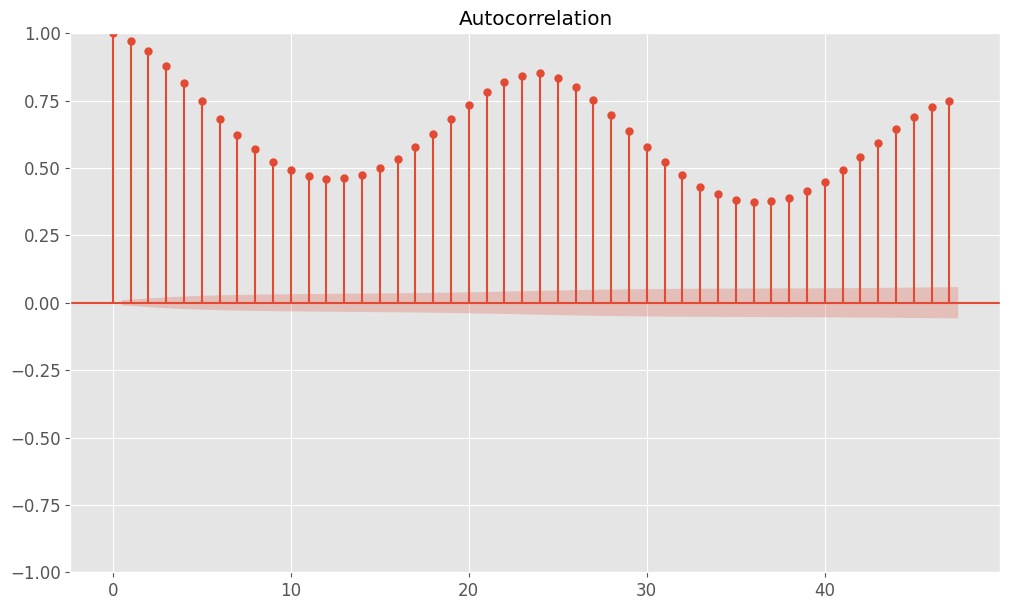

In [69]:
plot_acf(df_train.celsius)

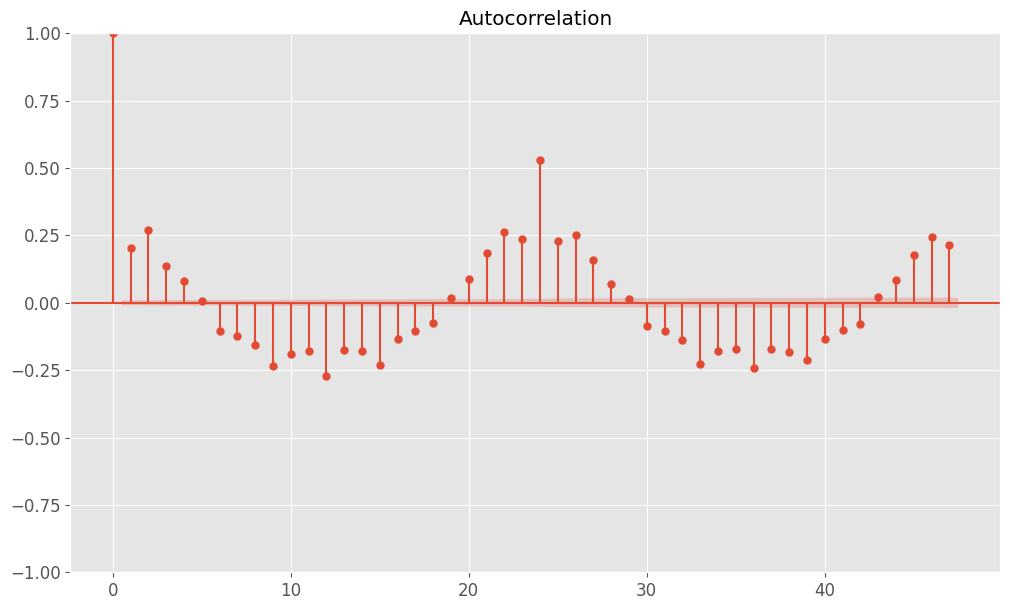

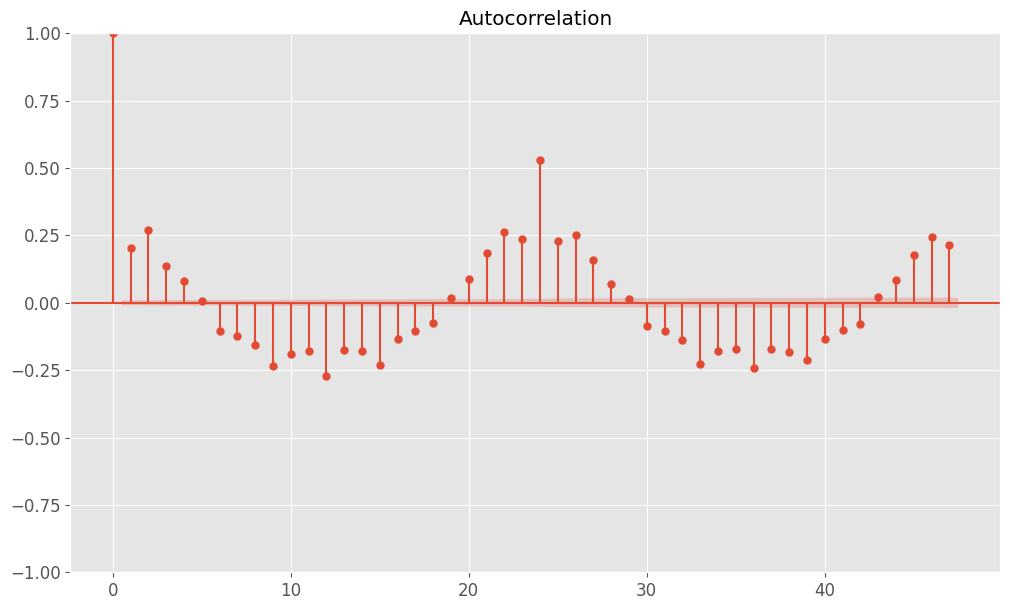

In [70]:
plot_acf(df_train.celsius.diff().dropna())

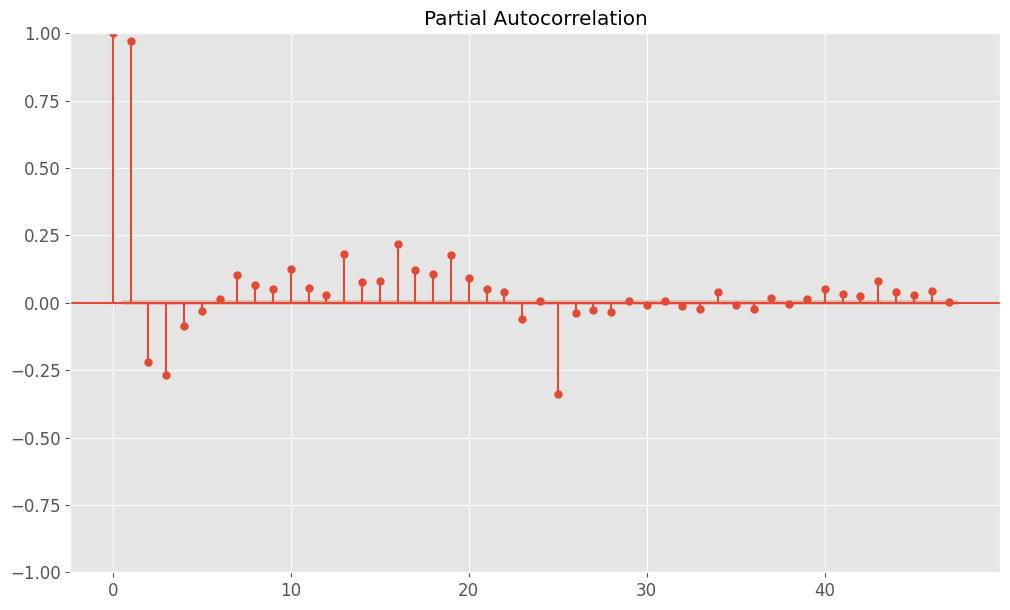

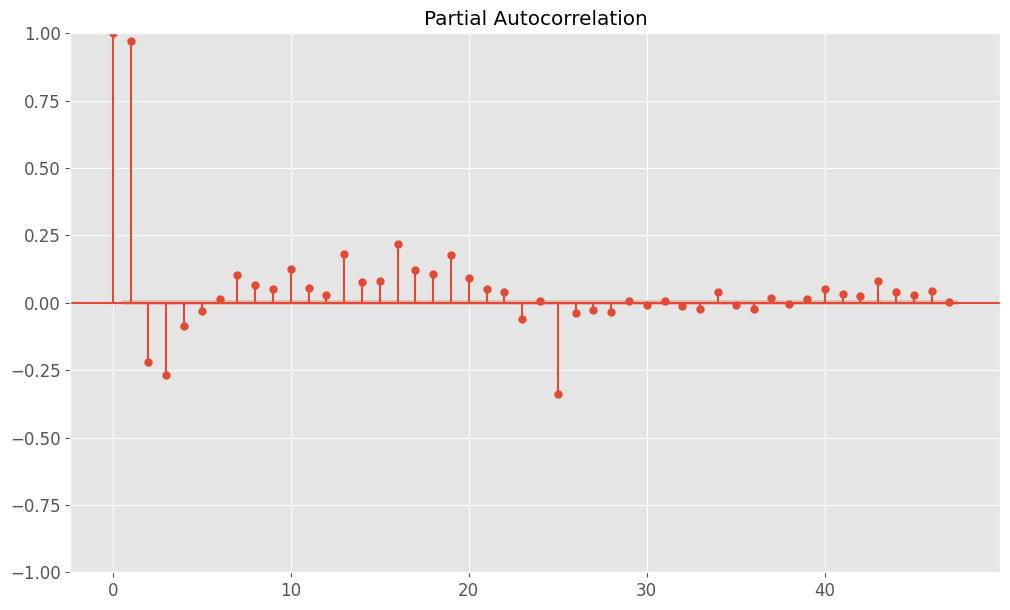

In [71]:
plot_pacf(df_train.celsius)

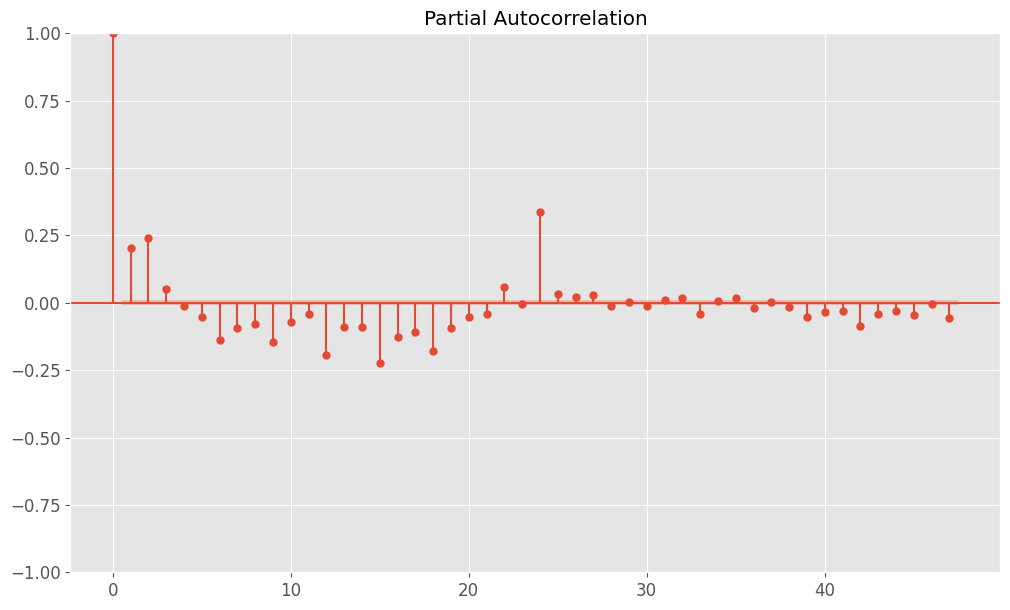

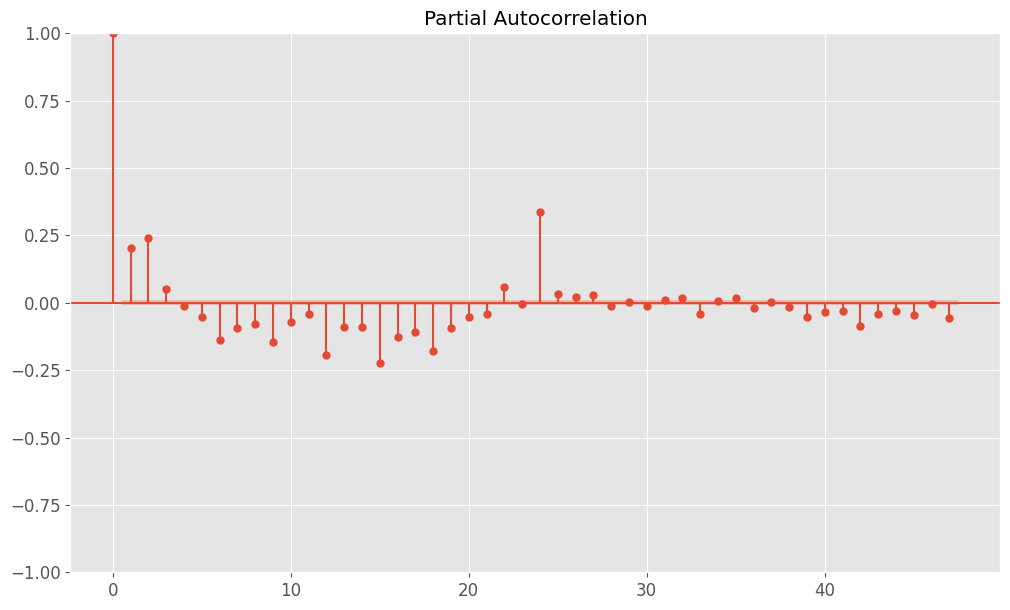

In [72]:
plot_pacf(df_train.celsius.diff().dropna())

In [77]:
modelo_arima_base = ARIMA(df_train.celsius, order = (2, 1, 2), freq = 'H')

In [79]:
modelo_v1 = modelo_arima_base.fit()  

In [83]:
dados_reais = df_train.celsius
previsoes = modelo_v1.fittedvalues

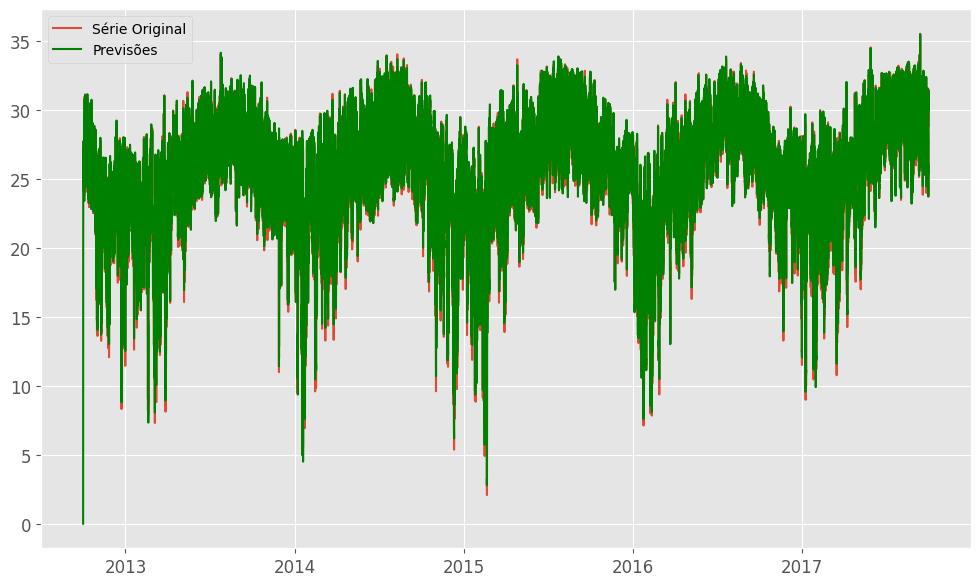

In [85]:
plt.plot(dados_reais, label = 'Série Original') 
plt.plot(previsoes, color = 'green', label = 'Previsões') 
plt.legend(loc = 'best') 
plt.show()

In [86]:
modelo_v1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                celsius   No. Observations:                43811
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -55652.319
Date:                Fri, 07 Oct 2022   AIC                         111314.638
Time:                        08:38:59   BIC                         111358.076
Sample:                    10-01-2012   HQIC                        111328.329
                         - 09-30-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9239      0.001   2584.070      0.000       1.922       1.925
ar.L2         -0.9912      0.001  -1389.653      0.000      -0.993      -0.990
ma.L1         -1.8915      0.002  -1254.896      0.000      -1.894      -1.889
ma.L2          0.9423      0.001    649.092      0.000       0.939       0.945
sigma2         0.7428      0.001    568.343      0.000       0.740       0.745
===================================================================================
Ljung-Box (L1) (Q):                 291.01   Jarque-Bera (JB):           3255519.13
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        45.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [89]:
 pred = modelo_v1.forecast(len(df_test.celsius), alpha = 0.05) 

In [90]:
df_pred["arima_1"] = pred

In [91]:
df_pred.head()

,baseline,baseline_year,arima_1
datetime,,,
2017-10-01 00:00:00,25.002769,25.501126,28.272067
2017-10-01 01:00:00,25.002769,25.501126,27.665796
2017-10-01 02:00:00,25.002769,25.501126,27.092040
2017-10-01 03:00:00,25.002769,25.501126,26.589108
2017-10-01 04:00:00,25.002769,25.501126,26.190203


<AxesSubplot: xlabel='datetime'>

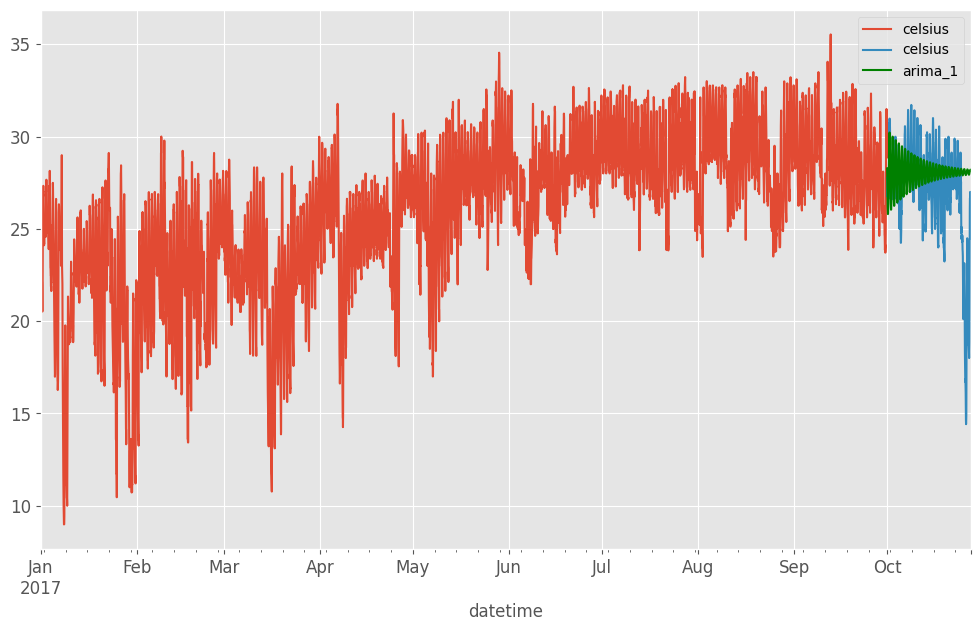

In [93]:
df_train["celsius"]["2017":].plot(legend="treino")
df_test["celsius"].plot(legend="teste")
df_pred["arima_1"].plot(legend="previsão", color="green")

In [94]:
rmse_arima_1 = mean_squared_error(df_test["celsius"].values, df_pred["arima_1"].values, squared=False)
mape_arima_1 = mean_absolute_percentage_error(df_test["celsius"].values, df_pred["arima_1"].values)

In [102]:
df_metrics.loc["arima_v1"] = [rmse_arima_1, mape_arima_1]
df_metrics

,RMSE,MAE
baseline,3.375403,0.109517
arima_v1,2.839791,0.076272


In [106]:
ndiffs(df_clean.celsius, test = 'adf') 

0

In [107]:
ndiffs(df_clean.celsius, test = 'kpss') 

1

In [157]:
# Avalia um modelo ARIMA
def avalia_modelo_arima(train, test, arima_order):
    
    model = ARIMA(train, order = arima_order, freq="H")
    model_fit = model.fit()
    predictions = model_fit.forecast(len(test))
        
    # Calcula o erro do modelo
    error = mean_squared_error(test, predictions, squared=False)
    return error

In [159]:
# Avalia as combinações de valores p, d e q para um modelo ARIMA
def avalia_melhor_arima(train, test, p_values, d_values, q_values):
    # Define variáveis de controle
    best_score, best_cfg = float("inf"), None
    
    # Loop pelos valores de p, d e q
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                print(f"Ordem:{order}")
                rmse = avalia_modelo_arima(train, test, order)
                if rmse < best_score:
                    best_score, best_cfg = rmse, order
                print('ARIMA%s RMSE = %.4f' % (order, rmse))

    print('\nMelhor Modelo ARIMA%s RMSE = %.4f' % (best_cfg, best_score))

In [160]:
p_values = [0, 1, 2, 3]
q_values = [0, 1, 2, 3]
d_values = [0, 1, 2, 3]

In [162]:
avalia_melhor_arima(df_clean.celsius, df_test.celsius, p_values, d_values, q_values)

Ordem:(0, 0, 0)
ARIMA(0, 0, 0) RMSE = 3.3587
Ordem:(0, 0, 1)
ARIMA(0, 0, 1) RMSE = 3.3597
Ordem:(0, 0, 2)
ARIMA(0, 0, 2) RMSE = 3.3604
Ordem:(0, 0, 3)
ARIMA(0, 0, 3) RMSE = 3.3624
Ordem:(0, 1, 0)
ARIMA(0, 1, 0) RMSE = 3.6982
Ordem:(0, 1, 1)
ARIMA(0, 1, 1) RMSE = 3.8162
Ordem:(0, 1, 2)
ARIMA(0, 1, 2) RMSE = 3.9930
Ordem:(0, 1, 3)
ARIMA(0, 1, 3) RMSE = 4.1356
Ordem:(0, 2, 0)
ARIMA(0, 2, 0) RMSE = 474.2139
Ordem:(0, 2, 1)
ARIMA(0, 2, 1) RMSE = 156.5103
Ordem:(0, 2, 2)
ARIMA(0, 2, 2) RMSE = 217.2645
Ordem:(0, 2, 3)
ARIMA(0, 2, 3) RMSE = 4.0034
Ordem:(0, 3, 0)
ARIMA(0, 3, 0) RMSE = 95950.5792
Ordem:(0, 3, 1)
ARIMA(0, 3, 1) RMSE = 482.9089
Ordem:(0, 3, 2)
ARIMA(0, 3, 2) RMSE = 160.0415
Ordem:(0, 3, 3)
ARIMA(0, 3, 3) RMSE = 218.7736
Ordem:(1, 0, 0)
ARIMA(1, 0, 0) RMSE = 3.3842
Ordem:(1, 0, 1)
ARIMA(1, 0, 1) RMSE = 3.3860
Ordem:(1, 0, 2)
ARIMA(1, 0, 2) RMSE = 3.3870
Ordem:(1, 0, 3)
ARIMA(1, 0, 3) RMSE = 3.3885
Ordem:(1, 1, 0)
ARIMA(1, 1, 0) RMSE = 3.9223
Ordem:(1, 1, 1)
ARIMA(1, 1, 1) RMSE = 4

In [172]:
modelo_arima_grid = ARIMA(df_train.celsius, order = (1, 1, 3), freq = 'H')

In [173]:
modelo_v2 = modelo_arima_grid.fit()  

In [174]:
dados_reais = df_train.celsius
previsoes = modelo_v2.fittedvalues

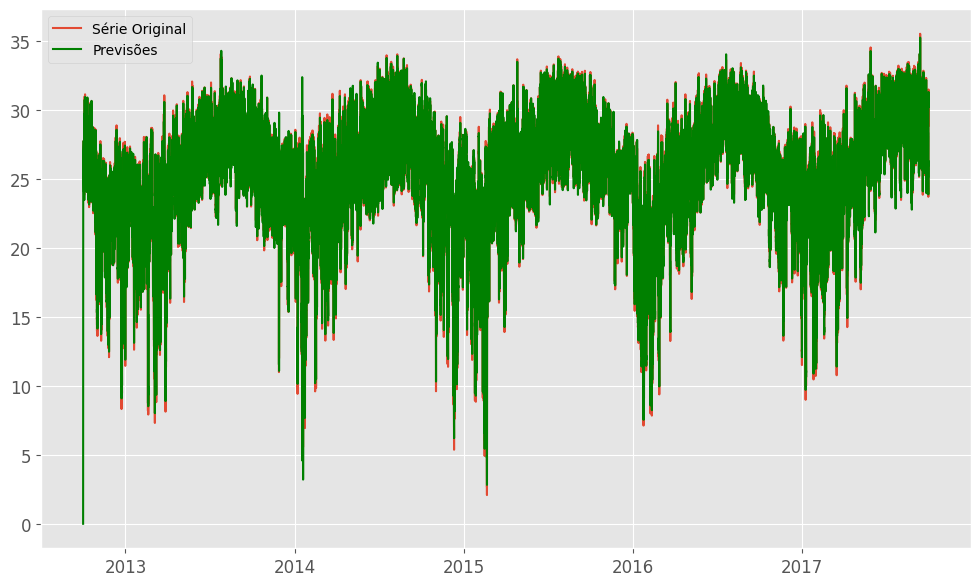

In [175]:
plt.plot(dados_reais, label = 'Série Original') 
plt.plot(previsoes, color = 'green', label = 'Previsões') 
plt.legend(loc = 'best') 
plt.show()

In [176]:
pred = modelo_v2.forecast(len(df_test.celsius), alpha = 0.05) 

In [177]:
df_pred["arima_grid"] = pred

<AxesSubplot: xlabel='datetime'>

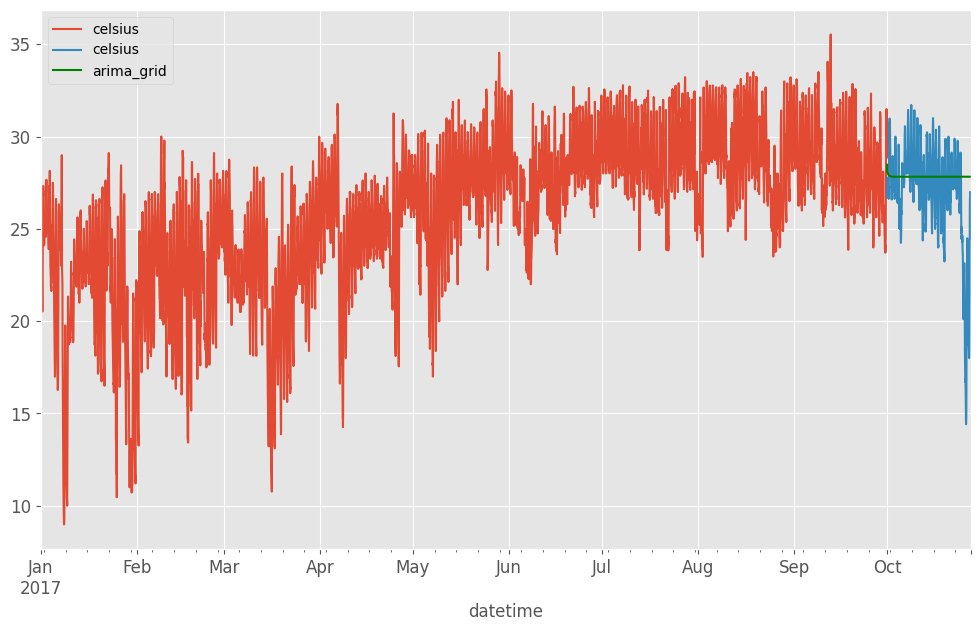

In [178]:
df_train["celsius"]["2017":].plot(legend="treino")
df_test["celsius"].plot(legend="teste")
df_pred["arima_grid"].plot(legend="previsão", color="green")

In [179]:
rmse_arima_grid = mean_squared_error(df_test["celsius"].values, df_pred["arima_grid"].values, squared=False)
mape_arima_grid = mean_absolute_percentage_error(df_test["celsius"].values, df_pred["arima_grid"].values)

In [180]:
df_metrics.loc["arima_v2"] = [rmse_arima_1, mape_arima_1]
df_metrics

,RMSE,MAE
baseline,3.375403,0.109517
arima_v1,2.839791,0.076272
arima_v2,3.257016,0.104019


In [182]:
import itertools

p = q = d = range(0,2)
pqd = list(itertools.product(p,q,d))

seasonal_pqd = [(x[0], x[1], x[2], 24) for x in pqd]
seasonal_pqd

[(0, 0, 0, 24),
 (0, 0, 1, 24),
 (0, 1, 0, 24),
 (0, 1, 1, 24),
 (1, 0, 0, 24),
 (1, 0, 1, 24),
 (1, 1, 0, 24),
 (1, 1, 1, 24)]

In [ ]:
aic_lista = []
for param in pqd:
    for param_seasonal in seasonal_pqd:
        model = SARIMAX(
            df_train.celsius, order=param, seasonal_order=param_seasonal
        )
        results = model.fit()
        aic_lista.append("ARIMA {} x {} - AIC: {}".format(param, param_seasonal, results.aic))

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.65184D+00    |proj g|=  1.55431D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   1.554D-08   4.652D+00
  F =   4.6518449870674710     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.3

 This problem is unconstrained.



At iterate    5    f=  4.06545D+00    |proj g|=  3.17114D-02

At iterate   10    f=  4.02704D+00    |proj g|=  9.17813D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     11     17      1     0     0   1.247D-06   4.027D+00
  F =   4.0270375187649590     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
